In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/tweedejaarsproject/

/content/drive/My Drive/Colab Notebooks/tweedejaarsproject


In [4]:
ls

0-10000-labeled.csv  BERT.ipynb  huggingface_stats.py  imdb_bert/  model.png


In [5]:
pd.read_csv('0-10000-labeled.csv')

,article,highlights,id,label
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,0.0
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,0.0
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,1.0
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,0.0
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,0.0
...,...,...,...,...
9995,"(Oprah.com) -- As a trained chef, restaurant o...",Chef Laura Pensiero: Don't let diet hijack you...,75cd2144a44f902e14b887bf927a08ad6b5fbf54,0.0
9996,"Islamabad, Pakistan (CNN) -- The Pakistani mil...",NEW: Taliban source says commander alive and w...,734ca9a754dd444ed50362375e256fd72d82def5,0.0
9997,(CNN) -- Bastian Schweinsteiger rescued a poin...,Midfielder Bastian Schweinsteiger rescues a po...,8ff4e932c84ed30759427a128879f0af1c8a156a,0.0
9998,"(CNN) -- Haiti's earthquake is creating ""a gen...","Experts say Haiti's earthquake is creating ""a ...",12e6c95b6f47092e953523ae556cb6391a7021f6,0.0


In [6]:
import huggingface_stats

In [7]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 4.6 MB/s 


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [8]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 237 kB 68.4 MB/s 
     |████████████████████████████████| 1.2 MB 46.5 MB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 1.1 MB 54.5 MB/s 
     |████████████████████████████████| 92 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 58.5 MB/s 
     |████████████████████████████████| 352 kB 38.0 MB/s 
     |████████████████████████████████| 48.3 MB 87 kB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 


In [9]:
import os
import shutil
import re
import string

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [10]:
from tensorflow.keras import layers

In [28]:
news_data = pd.read_csv('0-10000-labeled.csv', dtype = {'label': int})
news_data.loc[news_data['label'] == 0, 'label_txt'] = 'Not accident'
news_data.loc[news_data['label'] == 1, 'label_txt'] = 'Accident'
news_data.head()

,article,highlights,id,label,label_txt
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,0,Not accident
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,0,Not accident
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,1,Accident
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,0,Not accident
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,0,Not accident


In [33]:
news_features = np.array(news_data['article'])
news_labels = np.array(news_data['label'])

In [34]:
import nltk
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

preprocessor = huggingface_stats.Preprocessor(stemmer=EnglishStemmer(),
                                              stopwords=stopwords.words('english'),
                                              re_pattern=re.compile("[a-zA-Z]"))

# pas deze if-statement aan om keyword filteren aan of uit te zetten
filter_by_keywords = True
if filter_by_keywords:
    positive_keywords = ['accident','disaster','catastrophe','incident','near-miss', 'tragedy', 'victim',
                         'casualties','died','killed','damage','harm','hospital','hospitalized',
                         'wounded','succumbed','unscathed','evacuate','rescue','first responders','ambulance',
                         'first aid', 'sunk','fire','derailed','collision','poisoned','burned', 'safety']
    negative_keywords = ['gunman', 'suspect', 'attack', 'terror', 'war', 'bombing', 'militants', 'bombs',
                         'conflict', 'hijacking']
    preprocessor.init_keyword_filter(positive=positive_keywords,
                                     pos_threshold=3,
                                     negative=negative_keywords,
                                     neg_threshold=3)
    pass_filter = preprocessor.batch_keyword_filter(docs=news_features.tolist(), show_progress=True)
    news_features = news_features[np.array(pass_filter)]
    news_labels = news_labels[np.array(pass_filter)]
    print('\n')
    print(np.sum(np.array(pass_filter) == True), 'articles passed')
    print(np.sum(np.array(pass_filter) == False), 'articles did not pass')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 10000/10000 [02:14<00:00, 74.41it/s]



1802 articles passed
8198 articles did not pass


In [35]:
len(news_labels)

1802

In [36]:

from sklearn.model_selection import train_test_split
docs_train, docs_test, y_train, y_test = train_test_split(news_features, news_labels, test_size=.20)
docs_train, docs_val, y_train, y_val = train_test_split(docs_train, y_train, test_size=.20)


AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100


raw_train_ds = tf.data.Dataset.from_tensor_slices((docs_train, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((docs_val, y_val))
raw_test_ds = tf.data.Dataset.from_tensor_slices((docs_test, y_test))

raw_train_ds = raw_train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
raw_val_ds = raw_val_ds.batch(BATCH_SIZE)
raw_test_ds = raw_test_ds.batch(BATCH_SIZE)

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [37]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [38]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print("Article>", text_batch.numpy()[i])
    print("Label>", label_batch.numpy()[i])

Article> b'(CNN) -- Authorities in Cleveland, Ohio, brought in cadaver dogs Wednesday to search the childhood home of a registered sex offender accused in the deaths of 11 women. "We\'re just trying to cover all our bases," said Scott Wilson, spokesman for the FBI, which is assisting local detectives in the case. Anthony Sowell, 50, was arrested in October after authorities serving a search warrant in a rape case discovered six bodies in and around his current home. Subsequent searches turned up five more bodies, all African-American women. Authorities have said they are looking at the unsolved murders of three women in East Cleveland to determine whether they share any similarities with the remains found at Sowell\'s home. Wednesday\'s search comes a day after Sowell was indicted on 85 counts -- including aggravated murder, rape and kidnapping -- in the killings. In addition, Sowell is charged with "brutalizing" three other women and raping two of them, Cuyahoga County prosecutor Bill

In [64]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'albert_en_base'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/albert_en_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/albert_en_preprocess/3


In [65]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [66]:
text_test = ['a construction worker fell into a hole.']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [   2   21  900 7444 1139   77   21 3990    9    3    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [67]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [68]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/albert_en_base/2
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.3112846  -0.38816905  0.83476657 -0.360805   -0.5682504  -0.59534097
  0.2218903  -0.37367004  0.36275247 -0.9891055   0.9545626   0.2542015 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.37145334  0.04332843  0.90312874 ... -0.2761133   0.28342786
   1.8135979 ]
 [ 0.06460732  0.94462097  1.6923825  ... -1.1691967   1.007285
  -0.7017403 ]
 [-0.41246754  0.58232486  1.447728   ... -1.264025    0.26310894
   0.3236232 ]
 ...
 [ 0.09437487  0.1407868  -0.066617   ... -0.0934898   0.12792909
   0.23135144]
 [ 0.02070153  0.20605108  0.56652194 ...  0.36585057  1.2490236
  -0.22869828]
 [ 0.04889676  0.22763278  0.6085968  ...  0.42420238  1.3049681
  -0.24573016]]


In [69]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [70]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.41153905]], shape=(1, 1), dtype=float32)


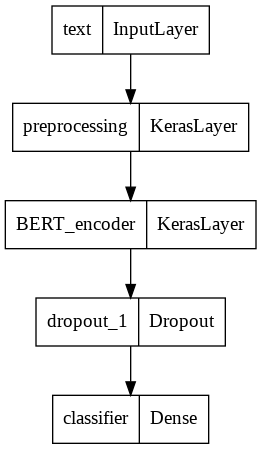

In [71]:
tf.keras.utils.plot_model(classifier_model)

In [72]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [73]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [74]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [76]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/5
 2/18 [==>...........................] - ETA: 35s - loss: 0.5686 - binary_accuracy: 0.7188

ResourceExhaustedError: ignored

In [51]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

6/6 [==============================] - 2s 298ms/step - loss: 0.4035 - binary_accuracy: 0.8310
Loss: 0.4035434126853943
Accuracy: 0.8310249447822571


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


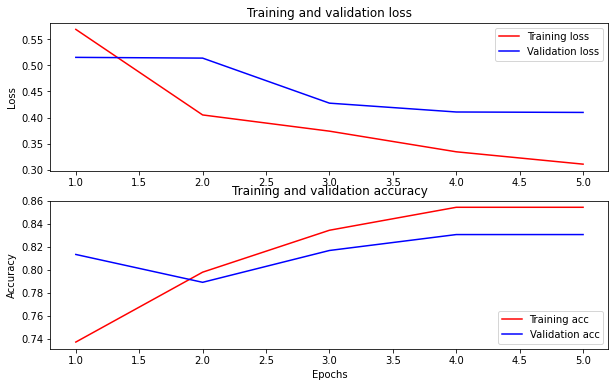

In [52]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [53]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [54]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [55]:
test_acc = np.array(docs_test)[np.array(y_test) == 1]
test_not_acc = np.array(docs_test)[np.array(y_test) == 0]

In [56]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30}\nscore: {results[i][0]:.6f}\n'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'a man died in a plane crash',
    'a new movie was released',
    'a man was murdered by a murderer',
    'a man fell off scaffolding and hurt his leg',
    'bees are pretty cool i decided'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: a man died in a plane crash   
score: 0.393104

input: a new movie was released      
score: 0.093903

input: a man was murdered by a murderer
score: 0.032130

input: a man fell off scaffolding and hurt his leg
score: 0.248524

input: bees are pretty cool i decided
score: 0.209795


Results from the model in memory:
input: a man died in a plane crash   
score: 0.393104

input: a new movie was released      
score: 0.093903

input: a man was murdered by a murderer
score: 0.032130

input: a man fell off scaffolding and hurt his leg
score: 0.248524

input: bees are pretty cool i decided
score: 0.209795




In [57]:
examples = test_acc[:10].tolist()

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))

print_my_examples(examples, reloaded_results)

input: San Juan, Puerto Rico (CNN)  -- Investigators don't know if the massive fire at a fuel storage facility near San Juan was deliberately started or was an accident, the agent in charge of the FBI's San Juan office said Monday. The blaze, which started with an explosion at the Caribbean Petroleum Corp. facility in Bayamon municipality early Friday, was extinguished Sunday, firefighters said. Some of the tanks continued to smolder and crews stood ready to fight any flare-up. "We don't know if it's a crime scene," said FBI Special Agent Luis Fraticelli. "We don't know if it's an accident, so we're not making any determinations at this point until our experts do their work, do their analysis and then provide input to us as to what they feel happened here." Puerto Rico is a territory of the United States. The FBI is investigating graffiti found on two San Juan tunnels that referred to a fire, Special Agent Harry Rodriguez said Friday. A spray-painted message on the tunnels, less than t

In [58]:
examples = test_not_acc[:10].tolist()

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))

print_my_examples(examples, reloaded_results)

input: (CNN) -- A British man was jailed Tuesday for raping two of his daughters and fathering nine children over 27 years, a case with echoes of Austria's Josef Fritzl. The two daughters were made pregnant 19 times; there were nine births, five miscarriages and five terminations. Seven of the children are alive but suffer genetic deformities. The father, who cannot be named for legal reasons banning the identification of his victims and the surviving children, pleaded guilty Tuesday at Sheffield Crown Court, northern England, and was sentenced to serve 25 life sentences to run concurrently. The judge said the minimum term the 56-year-old rapist should serve in jail should be 19½ years. South Yorkshire Police Chief Superintendent Simon Torr said, "The victims of these terrible crimes have asked me to state the following: 'His detention in prison brings us only the knowledge that he cannot physically touch us again. The suffering he has caused will continue for many years, and we must n

In [59]:
test_scores = tf.sigmoid(reloaded_model(tf.constant(docs_test)))

In [60]:
test_predictions = tf.math.round(test_scores)

In [61]:
test_predictions = test_predictions.numpy().ravel().astype(int)

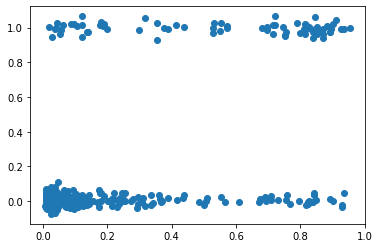

In [62]:
plt.scatter(test_scores, y_test + np.random.normal(loc=0.0, scale=0.03, size=len(y_test)))

In [63]:

from sklearn.metrics import classification_report
print(classification_report(y_test, test_predictions, target_names=['not accident', 'accident']))

              precision    recall  f1-score   support

not accident       0.90      0.89      0.89       283
    accident       0.61      0.63      0.62        78

    accuracy                           0.83       361
   macro avg       0.75      0.76      0.76       361
weighted avg       0.84      0.83      0.83       361

